<a href="https://colab.research.google.com/github/yunjinchoidev/Kaggle/blob/main/Bike_Sharing_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
# 데이터 경로
import os
os.environ['KAGGLE_USERNAME']='yunjinchoidev'
os.environ['KAGGLE_KEY']='3d90c15ed3e0411bd30537de9f540179'
!kaggle competitions download -c bike-sharing-demand
!unzip '*.zip'

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sampleSubmission.csv')

100% 189k/189k [00:00<00:00, 769kB/s]
100% 189k/189k [00:00<00:00, 767kB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [2]:
train = train[train['weather'] != 4]


In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [4]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

In [5]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis=1)

In [6]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

In [7]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

In [9]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

In [10]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [11]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)


최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


In [12]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


In [13]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


In [14]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


In [15]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


In [16]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


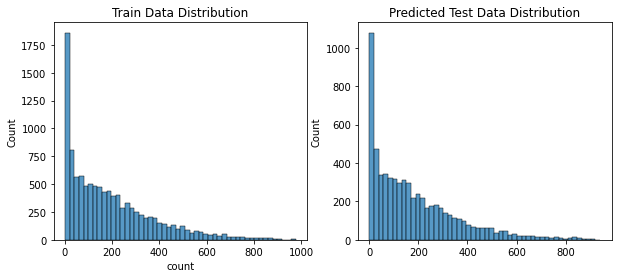

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [18]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)

In [20]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "드디어 첫번째 커밋"

100% 244k/244k [00:01<00:00, 184kB/s]
Successfully submitted to Bike Sharing Demand